In [1]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import matplotlib.pyplot as plt

In [2]:
market_data = pd.read_parquet('data/US/test_mkt_data.pq')
GICS = pd.read_parquet('data/US/test_GICS.pq')
P = pd.read_parquet('data/US/test_universe_table.pq')
P.index.names = ['Date']
R = market_data['close'].unstack().reindex_like(P).pct_change()
market_data.dropna().sample(5)

C:\Users\marti\AppData\Local\Temp\ipykernel_26256\2249672503.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  R = market_data['close'].unstack().reindex_like(P).pct_change()


,,datetime,open,high,low,close,adj_close,volume,MktCap
Date,Ticker,,,,,,,,
2024-01-11,SWN,2024-01-11,6.80,7.020,6.665,6.72,6.7200,85232648,2.869573e+12
2021-01-05,WY,2021-01-05,32.87,33.320,32.805,33.12,28.7106,3908983,2.204016e+12
2023-06-13,PARA,2023-06-13,16.61,16.890,16.560,16.62,16.4556,9224925,2.883228e+12
2021-02-02,AIZ,2021-02-02,136.05,136.295,133.380,133.51,125.7366,697166,2.266225e+12
2022-02-15,MOS,2022-02-15,44.57,45.830,42.910,45.58,43.9721,6181683,2.819836e+12


In [3]:
volume = market_data['volume'].unstack().ffill(limit=5)
close = market_data['close'].unstack()
open = market_data['open'].unstack()
low = market_data['low'].unstack()
high = market_data['high'].unstack()
mean_price = (close+ open + low).fillna(0) / 3


In [4]:
close_low = (close - low).div(close,0)
high_close = (high - close).div(close,0) 
high_low = (high - low).div(close,0) 
diff_1 = close_low - high_close
div_1 = diff_1.div(high_low,0)
mult_1 = volume.mul(div_1,0)
z_score = mult_1.rolling(5).mean()
z_score = z_score.reindex_like(P).ffill()

C:\Users\marti\AppData\Local\Temp\ipykernel_26256\394737094.py:4: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  signal = signal[P].groupby(GICS['gicind'],axis=1).apply(center)


Sharpe                     1.8
Daily Turnover (%)        77.4
biais (bp)                 2.9
Sharpe since 2022          0.8
biais  since 2022 (bp)     1.2
dtype: float64

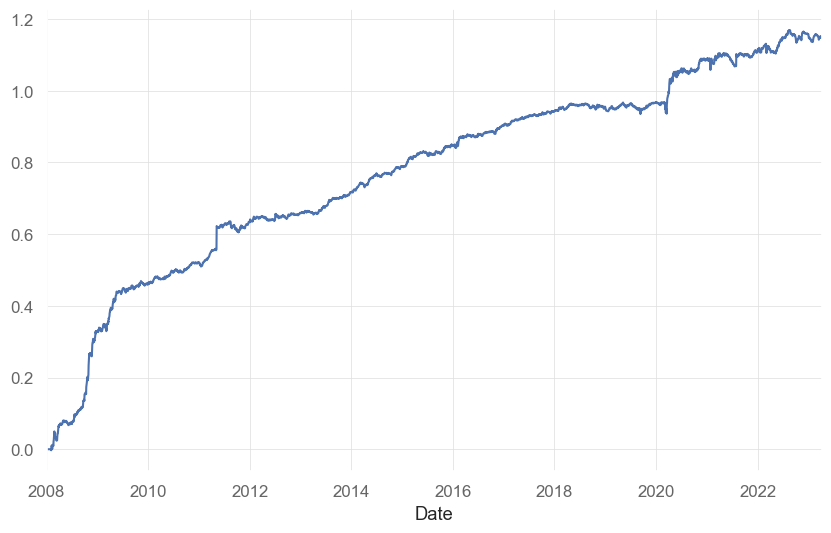

In [5]:
signal = z_score[P].rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
signal[signal.abs()<0.5] = None

signal = signal[P].groupby(GICS['gicind'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)

PNL = (signal[P].shift()*R[P]).sum(1)
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,
           'Daily Turnover (%)':turnover *100,
           'biais (bp)':PNL.mean()*1e4,
           'Sharpe since 2022' : sharpe(PNL.loc['2022':]),
           'biais  since 2022 (bp)':PNL.loc['2022':].mean()*1e4}).round(1)